In [1]:
import os
from skimage import io, color
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
from torchvision import transforms
import torch_directml
from tqdm import tqdm
import lightning as L
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint, RichProgressBar

%matplotlib inline

device = torch_directml.device()
print(f"Using device: {device}")

Using device: privateuseone:0


In [2]:
class ImageColorizerDataset(Dataset):
    def __init__(self, root_dir, train=True, n_samples=1281167, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.n_samples = n_samples
        self.train = train
        self.annotations_file = pd.read_csv(os.path.join(root_dir, "train.csv" if train else "test.csv"), header=None)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        """Loads an image from a file, converts to LAB color space, and returns (L, [A; B])."""
        image_path = os.path.join(self.root_dir, self.annotations_file.iloc[idx, 0])

        rgb_img = io.imread(image_path)
        lab_img = color.rgb2lab(rgb_img)
        
        # split into L, A, B channels
        l, ab = lab_img[:, :, 0], lab_img[:, :, 1:]

        if self.transform:
            l = self.transform(l)
        if self.target_transform:
            ab = self.target_transform(ab)

        return l.float(), ab.float()

In [3]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = ImageColorizerDataset(root_dir="./data", train=True, transform=transform, target_transform=transform, n_samples=10000)
val_data = ImageColorizerDataset(root_dir="./data", train=False, transform=transform, target_transform=transform, n_samples=1000)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)


def get_train_images(num):
    return torch.stack([train_data[i][0] for i in range(num)], dim=0)

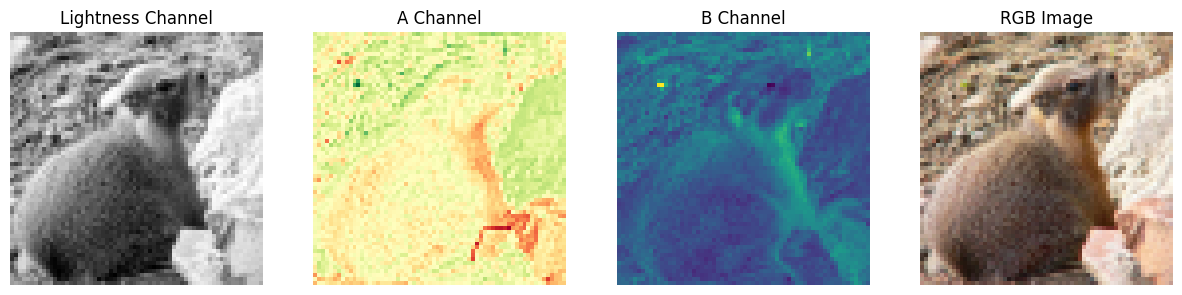

In [4]:
l, ab = next(iter(train_dataloader))

rgb_mean = read_image(os.path.join("./data", "mean.png")).permute(1, 2, 0).numpy() / 255.0
rgb_stdev = read_image(os.path.join("./data", "stdev.png")).permute(1, 2, 0).numpy() / 255.0

fig, ax = plt.subplots(1, 4, figsize=(15, 7))
ax[0].imshow(l[0].squeeze(), cmap="gray")
ax[0].set_title("Lightness Channel")
ax[0].set_axis_off()

ax[1].imshow(ab[0,0], cmap="RdYlGn_r")
ax[1].set_title("A Channel")
ax[1].set_axis_off()

ax[2].imshow(ab[0, 1])
ax[2].set_title("B Channel")
ax[2].set_axis_off()

# stack l and ab along the channel dimension (axis 0)
lab = np.concatenate((l[0].numpy(), ab[0].numpy()), axis=0).transpose(1, 2, 0)
rgb = color.lab2rgb(lab)

ax[3].imshow(rgb, interpolation=None)
ax[3].set_title("RGB Image")
ax[3].set_axis_off()

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: callable = nn.GELU):
        super().__init__()

        c_hid = base_channel_size
        
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 64x64 -> 32x32
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2), # 32x32 -> 16x16
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2), # 16x16 -> 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2), # 8x8 -> 4x4
            act_fn(),
            nn.Flatten(),
            nn.Linear((2 * c_hid) * (4 * 4), latent_dim),
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self, num_output_channels: int, base_channel_size: int, latent_dim: int, act_fn: callable = nn.GELU):
        super().__init__()

        c_hid = base_channel_size

        self.linear = nn.Sequential(
            nn.Linear(latent_dim, (2 * c_hid) * (4 * 4)),
            act_fn(),
        )

        self.net = nn.Sequential(
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, stride=2, padding=1, output_padding=1), # 4x4 -> 8x8
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, stride=2, padding=1, output_padding=1), # 8x8 -> 16x16
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, stride=2, padding=1, output_padding=1), # 16x16 -> 32x32
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, stride=2, padding=1, output_padding=1), # 32x32 -> 64x64
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_output_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.shape[0], -1, 4, 4)
        x = self.net(x)

        return x

In [7]:
class Autoencoder(L.LightningModule):
    def __init__(
        self,
        base_channel_size: int = 32,
        latent_dim: int = 256,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 1,
        num_output_channels: int = 2,
        act_fn: callable = nn.GELU,
        width: int = 64,
        height: int = 64,
    ):
        super().__init__()

        self.save_hyperparameters()
        self.encoder = encoder_class(
            num_input_channels=num_input_channels,
            base_channel_size=base_channel_size,
            latent_dim=latent_dim,
            act_fn=act_fn,
        )
        self.decoder = decoder_class(
            num_output_channels=num_output_channels,
            base_channel_size=base_channel_size,
            latent_dim=latent_dim,
            act_fn=act_fn,
        )

        self.example_input_array = torch.zeros(batch_size, num_input_channels, width, height)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def _get_loss(self, batch):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.mse_loss(y_hat, y, reduction="none")
        loss = loss.sum(dim=(1, 2, 3)).mean(dim=(0))
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=5, min_lr=1e-6)
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }
    
    def training_step(self, batch, batch_idx):
        loss = self._get_loss(batch)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_loss(batch)
        self.log("val_loss", loss)
        return loss
    

In [9]:
def train_imagenet(latent_dim: int):
    trainer = L.Trainer(
        default_root_dir=os.path.join("./saved_models/model2/", f"imagenet_{latent_dim}"),
        log_every_n_steps=10,
        accelerator="auto",
        devices=1,
        max_epochs=500,
        callbacks=[
            ModelCheckpoint(save_weights_only=True),
            LearningRateMonitor("epoch"),
        ]
    )

    trainer.logger._log_graph = True  # Allow logging of model graph
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    pretrained_filename = os.path.join("./saved_models/model2/", f"imagenet_{latent_dim}.ckpt")
    if os.path.isfile(pretrained_filename):
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        model = Autoencoder(base_channel_size=64, latent_dim=latent_dim)
        trainer.fit(model, train_dataloader, val_dataloader)
    
    val_result = trainer.validate(model, dataloaders=val_dataloader, verbose=False)
    
    return model, val_result

In [10]:
model, val_result = train_imagenet(256)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/pavva/Projects/image-colorizer/venv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/pavva/Projects/image-colorizer/venv/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory saved_models/model2/imagenet_256/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_

┏━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃   ┃ Name    ┃ Type    ┃ Params ┃        In sizes ┃       Out sizes ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 0 │ encoder │ Encoder │  1.3 M │ [32, 1, 64, 64] │       [32, 256] │
│ 1 │ decoder │ Decoder │  1.5 M │       [32, 256] │ [32, 2, 64, 64] │
└───┴─────────┴─────────┴────────┴─────────────────┴─────────────────┘
Trainable params: 2.8 M                                                         
Non-trainable params: 0                                                         
Total params: 2.8 M                                                             
Total estimated model params size (MB): 11                                      


Output()

/home/pavva/Projects/image-colorizer/venv/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory saved_models/model2/imagenet_256/lightning_logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


/home/pavva/Projects/image-colorizer/venv/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: 
UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

Output()

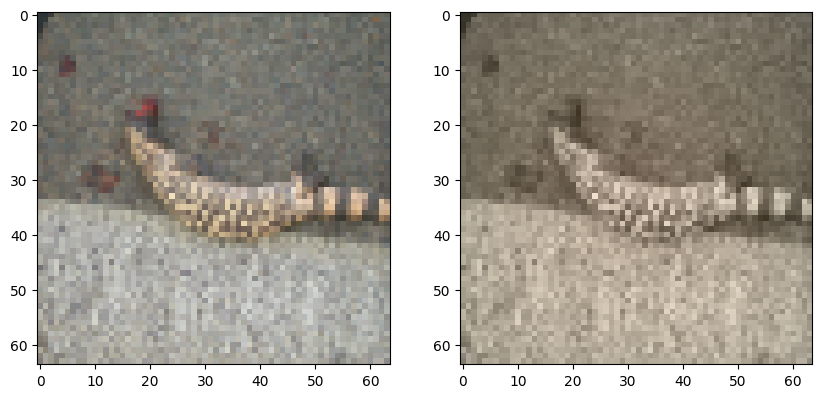

In [24]:
from skimage.color import lab2rgb

# test the model
l, ab = next(iter(train_dataloader))
l = l.to(model.device)
with torch.no_grad():
    model.eval()
    ab_hat = model(l)
    model.train()

rgb = torch.cat([l, ab], dim=1)
rgb = rgb.cpu().numpy().transpose(0, 2, 3, 1)
rgb = lab2rgb(rgb)

rgb_hat = torch.cat([l, ab_hat], dim=1)
rgb_hat = rgb_hat.cpu().numpy().transpose(0, 2, 3, 1)
rgb_hat = lab2rgb(rgb_hat)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(rgb[0])
axes[1].imshow(rgb_hat[0])
